# Exploration Notebook (UCI-ID 186, Wine Quality)

## Imports

In [1]:

%load_ext autoreload
%autoreload 2

In [4]:

import networkx as nx
import pandas as pd
import seaborn as sb
import umap.plot
from ucimlrepo import fetch_ucirepo

In [5]:
import sys

sys.path.append("../")
import evaluation
import visualization
import processing
from embedding_obj import EmbeddingObj
from dash_overlay import DashOverlay


## Workflow Example

In [6]:
# fetch dataset (available at https://archive.ics.uci.edu/dataset/186/wine+quality)
image_segmentation = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets, dtype="float32")

target_feature = "pH"
labels = pd.Categorical(y["quality"]).codes

X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


<Axes: ylabel='Count'>

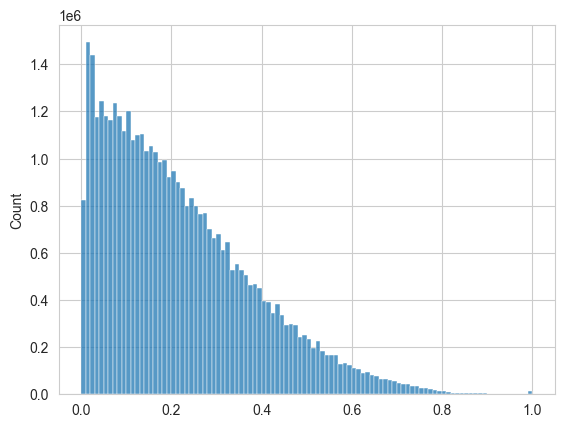

In [10]:
connectivity_pairwise = processing.compute_pairwise_dist(X, [target_feature])
sb.histplot(connectivity_pairwise.flatten(), bins=100)

### 0. Compute initial UMAP-Embedding

In [11]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_
connectivity_umap_knn = umap_mapper.graph_

D:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [12]:
graph_umap_knn = nx.Graph(connectivity_umap_knn)
edge_weights_umap_knn = [
    graph_umap_knn[u][v]["weight"] for u, v in graph_umap_knn.edges()
]

graph_knn_feat, edge_weights_knn_feat = processing.compute_knn(X, [target_feature],
                                                               n_neighbors=5)

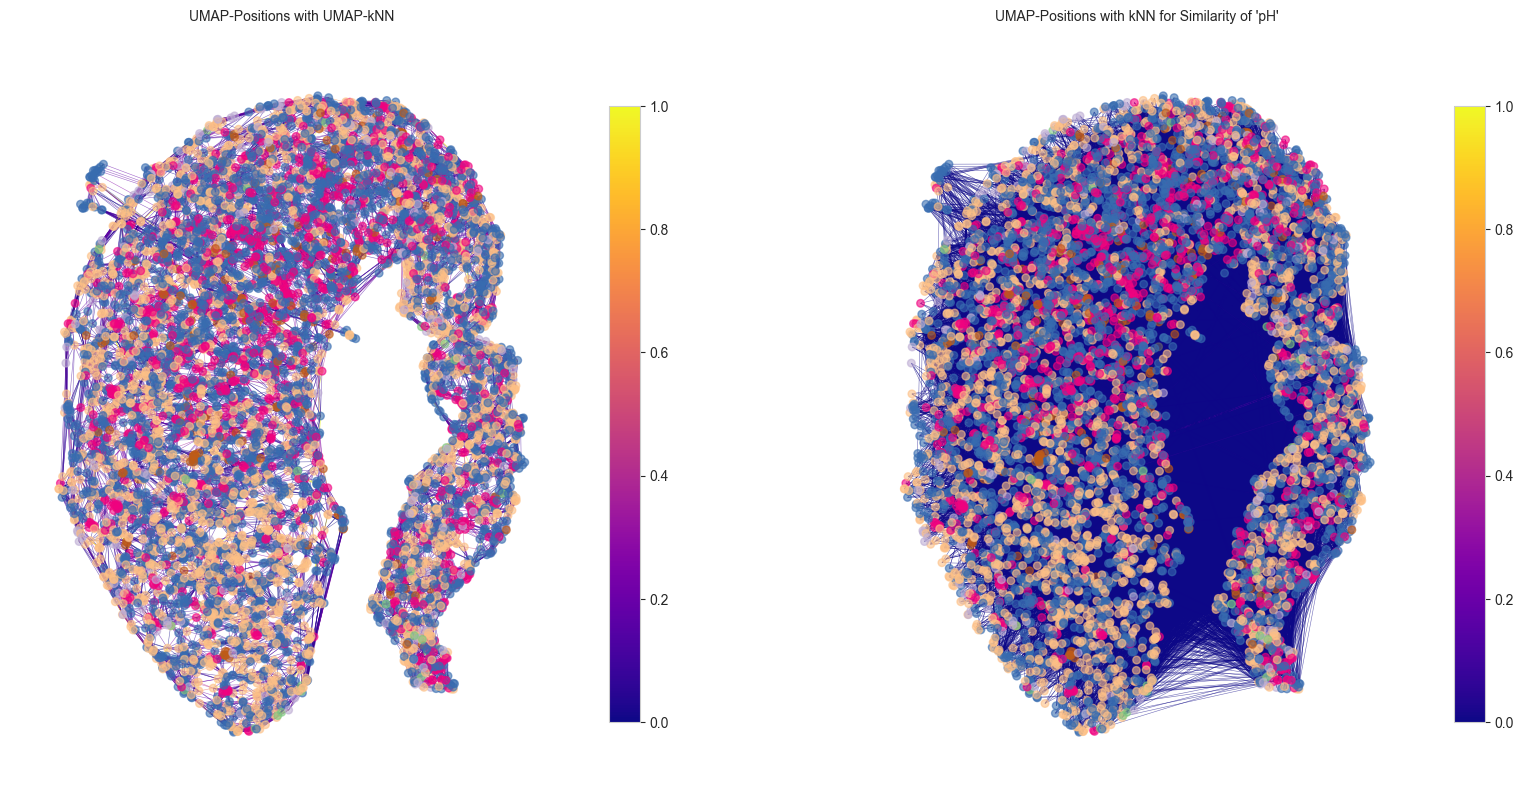

In [18]:
knn_list = [EmbeddingObj(graph=graph_umap_knn, embedding=umap_embedding,
                         edge_weights=edge_weights_umap_knn,
                         title="UMAP-Positions with UMAP-kNN"),
            EmbeddingObj(graph=graph_knn_feat, embedding=umap_embedding,
                         edge_weights=edge_weights_knn_feat,
                         title=f"UMAP-Positions with kNN for Similarity of '{target_feature}'")]

visualization.display_graphs(knn_list,
                             labels,
                             figsize_columns=2,
                             figsize=(20, 10))

### 1. Compute modified Embeddings

In [20]:
embeddings = processing.fit(X, umap_embedding, [target_feature],
                            iterations=[1, 3, 5, 10])

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  3
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  5
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  10
Computation finished
------------------------------------------------------------


### 2. Add Metrics to modified Embeddings

In [23]:
embeddings = evaluation.compute_pairwise_metrics(X, embeddings)
embeddings = evaluation.compute_global_metrics(X, embeddings, [target_feature])
embeddings[0].metrics_info()

------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  1
Computation time:  1.5109972953796387
------------------------------------------------------------
------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  3
Computation time:  1.3050355911254883
------------------------------------------------------------
------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  5
Computation time:  1.277965784072876
------------------------------------------------------------
------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  10
Computation time:  1.2149996757507324
------------------------------------------------------------
------------------------------------------------------------
Computing global metrics for embedding with marker:  1
Computation time

### 3. Visualize Results

### 3.1 Static Graphs

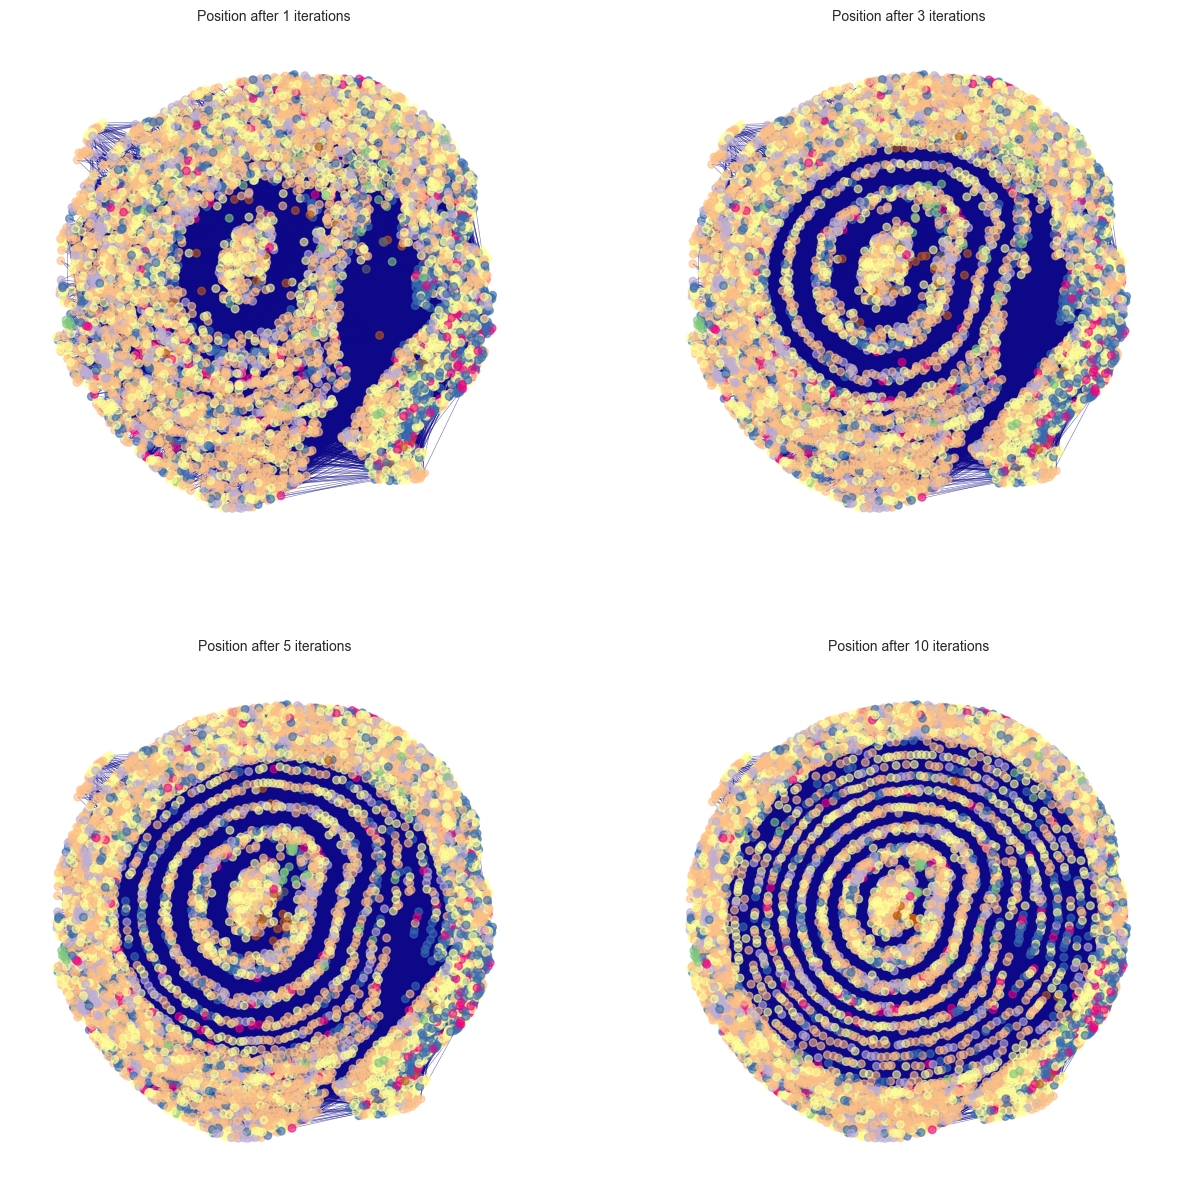

In [24]:
visualization.display_graphs(embeddings, X[target_feature], show_cbar=False)

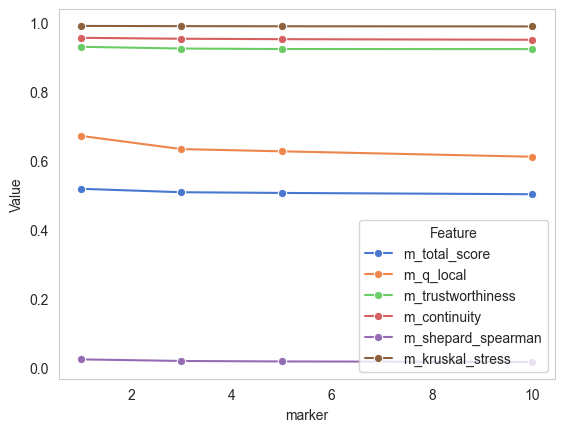

In [12]:
metrics_df = evaluation.metrics_report(embeddings)
visualization.plot_metrics_report(metrics_df)

In [11]:
evaluation.metrics_report(embeddings)

,marker,m_total_score,metric_jaccard (size),m_q_local,m_trustworthiness,m_continuity,m_shepard_spearman,m_kruskal_stress
0,1.0,0.517960,6497.0,0.671329,0.929889,0.955903,0.023112,0.990430
1,3.0,0.507996,6497.0,0.633163,0.924828,0.953260,0.018503,0.989773
2,5.0,0.505944,6497.0,0.626636,0.923378,0.951950,0.017151,0.989396
3,10.0,0.502252,6497.0,0.610999,0.923173,0.950332,0.015740,0.988985


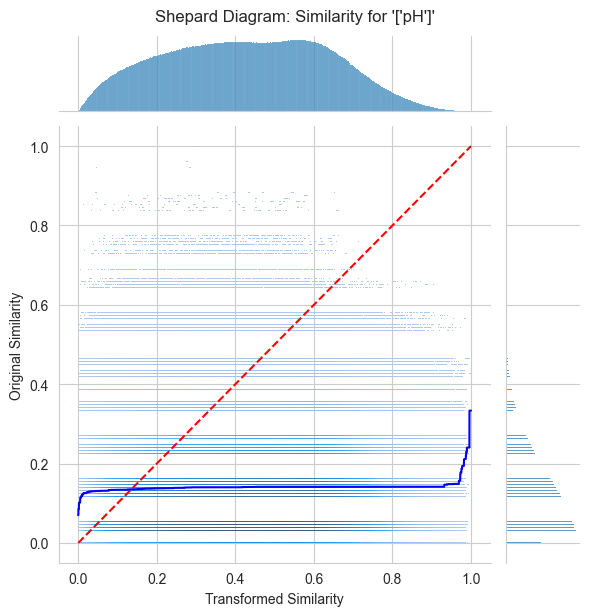

In [9]:
visualization.plot_shepard_diagram(X, embeddings[0], [target_feature])

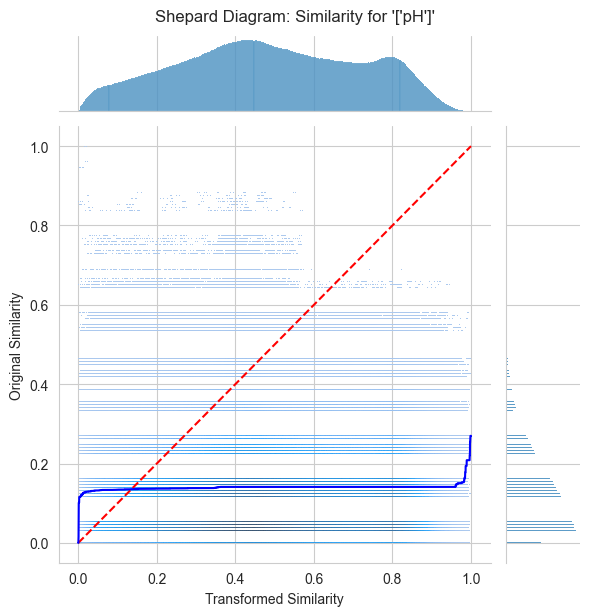

In [10]:
visualization.plot_shepard_diagram(X, embeddings[3], [target_feature])

### 3.2 Interactive Dash-App

In [26]:
# utils.save_pickle(embeddings)

In [7]:
# import utils
# embeddings = utils.load_pickle(filename="results_20250408-155308")

In [13]:
dash_app = DashOverlay(embeddings)

In [14]:
dash_app.run()